# Autonomous Driving Perception Lab (COCO Vehicles + KITTI Flow)

This Colab has two practical modules commonly used in camera-based autonomous driving:

## Part A — Vehicle-like Object Detection (COCO)
We fine-tune a 2D detector on **vehicle-like classes only**:
- bicycle, car, motorcycle, bus, truck

We will:
1) filter COCO annotations to keep only these classes  
2) remap labels to a contiguous set `{1..K}` (background=0)  
3) train a Faster R-CNN detector  
4) evaluate using COCO API (bbox AP) for the selected classes  
5) visualize post-training predictions (GT vs predicted boxes)

## Part B — Optical Flow Prediction (KITTI 2015)
We run a pretrained RAFT model on KITTI Flow 2015:
1) load KITTI image pairs and ground-truth flow  
2) fix model input constraints (H,W must be divisible by 8) using padding  
3) compute metrics (EPE and bad-pixel rate)  
4) visualize GT flow and predicted flow on multiple scenes

**Goal:** understand how detection and motion estimation are implemented and evaluated in practice.


## Part A.1 — Setup

We use:
- **PyTorch / Torchvision** for the model and training loop
- **pycocotools** for official COCO evaluation (`COCOeval`)
- COCO dataset format: images + JSON annotations

Key detail: Torchvision detection models expect targets in a specific dictionary format:
- `boxes`: FloatTensor [N,4] in (x1,y1,x2,y2)
- `labels`: IntTensor [N]
- `image_id`, `area`, `iscrowd` for evaluation compatibility


## Part A.2 — Vehicle-like Class Filtering + Label Remapping

COCO has many categories (80), but for autonomous driving we often care about "vehicle-like" objects.

We keep only these COCO categories:
- bicycle (id=2)
- car (id=3)
- motorcycle (id=4)
- bus (id=6)
- truck (id=8)

However, Torchvision detection training expects class labels to be contiguous (e.g., 1..K).
So we remap COCO category IDs to contiguous training labels:
- COCO id → contiguous label: {2→1, 3→2, 4→3, 6→4, 8→5}
Background is always label 0.

Later, during COCO evaluation, we must map predictions back:
- contiguous label → COCO category id
{1→2, 2→3, 3→4, 4→6, 5→8}

In [1]:
import os, random, time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as TF
from torchvision.datasets import CocoDetection
from pycocotools.cocoeval import COCOeval

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# COCO "vehicle-like" category IDs (COCO category_id -> name)
# bicycle=2, car=3, motorcycle=4, bus=6, truck=8  :contentReference[oaicite:3]{index=3}
VEHICLE_COCO_CATS = {
    2: "bicycle",
    3: "car",
    4: "motorcycle",
    6: "bus",
    8: "truck",
}

# Remap COCO category_id -> contiguous training label in [1..K]
COCO_TO_CONTIG = {coco_id: i+1 for i, coco_id in enumerate(sorted(VEHICLE_COCO_CATS.keys()))}
CONTIG_TO_COCO = {v: k for k, v in COCO_TO_CONTIG.items()}

print("COCO_TO_CONTIG:", COCO_TO_CONTIG)

Device: cuda
COCO_TO_CONTIG: {2: 1, 3: 2, 4: 3, 6: 4, 8: 5}


## Part A.3 — Dataset: COCO Vehicle-only Wrapper

`torchvision.datasets.CocoDetection` returns:
- a PIL image
- a list of raw annotation dicts per image (COCO format)

But our model expects:
- image tensor in [0,1]
- a `target` dict containing (boxes, labels, ...)

This wrapper performs:
1) load image + annotations for an image_id
2) filter annotations to vehicle-like categories
3) convert boxes from COCO `[x,y,w,h]` to `[x1,y1,x2,y2]`
4) map COCO category IDs → contiguous labels
5) optional augmentation (horizontal flip) with correct box updates

**Note:** `drop_empty=True` in training removes images that have no vehicle boxes after filtering.
This improves training stability and makes batches more informative.


In [2]:
class CocoVehicleOnly(Dataset):
    """
    COCO detection dataset filtered to vehicle-like classes only.
    Returns (img_tensor, target_dict) in torchvision detection format.
    """
    def __init__(self, img_folder, ann_file, train=True, drop_empty=True):
        self.base = CocoDetection(img_folder, ann_file)
        self.coco = self.base.coco
        self.ids = list(self.base.ids)

        self.train = train
        self.drop_empty = drop_empty

        # Pre-filter image ids if drop_empty=True to speed training & avoid empty targets
        if self.drop_empty:
            kept = []
            for img_id in self.ids:
                ann_ids = self.coco.getAnnIds(imgIds=[img_id], iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                has_vehicle = any(a.get("category_id") in COCO_TO_CONTIG and a.get("bbox", [0,0,0,0])[2] > 1 and a.get("bbox",[0,0,0,0])[3] > 1
                                  for a in anns)
                if has_vehicle:
                    kept.append(img_id)
            self.ids = kept

    def __len__(self):
        return len(self.ids)

    def _augment(self, img, target):
        # Minimal augmentation: horizontal flip
        if self.train and random.random() < 0.5:
            img = TF.hflip(img)
            w, h = img.size
            boxes = target["boxes"].clone()
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes
        return img, target

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.base.root, img_info["file_name"])

        from PIL import Image
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=[img_id], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels, areas, iscrowd = [], [], [], []
        for a in anns:
            coco_cat = a.get("category_id")
            if coco_cat not in COCO_TO_CONTIG:
                continue

            x, y, w, h = a["bbox"]  # COCO bbox is [x,y,w,h]
            if w <= 1 or h <= 1:
                continue

            boxes.append([x, y, x + w, y + h])
            labels.append(COCO_TO_CONTIG[coco_cat])  # contiguous label
            areas.append(a.get("area", w * h))
            iscrowd.append(a.get("iscrowd", 0))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        areas = torch.tensor(areas, dtype=torch.float32)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd,
        }

        img, target = self._augment(img, target)
        img = TF.to_tensor(img)  # float tensor in [0,1], [3,H,W]
        return img, target


def collate_fn(batch):
    return tuple(zip(*batch))


## Part A.4 — Dataloaders

We create:
- `train_loader` for COCO train2017 (vehicle-only)
- `val_loader` for COCO val2017 (vehicle-only evaluation)

Important:
- Detection models take a *list* of images and a *list* of targets
- Therefore we use a custom `collate_fn` that returns lists instead of stacking tensors

In [3]:
COCO_ROOT = "/home/frank/Desktop/archive/coco2017"  # change if local
train_imgs = os.path.join(COCO_ROOT, "train2017")
val_imgs   = os.path.join(COCO_ROOT, "val2017")
train_ann  = os.path.join(COCO_ROOT, "annotations", "instances_train2017.json")
val_ann    = os.path.join(COCO_ROOT, "annotations", "instances_val2017.json")

train_ds = CocoVehicleOnly(train_imgs, train_ann, train=True, drop_empty=True)
val_ds   = CocoVehicleOnly(val_imgs,   val_ann,   train=False, drop_empty=False)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("Train images:", len(train_ds), "Val images:", len(val_ds))


loading annotations into memory...
Done (t=6.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
Train images: 19759 Val images: 5000


## Part A.5 — Model: Faster R-CNN for K Vehicle Classes

We start from a COCO-pretrained Faster R-CNN backbone and replace the classifier head.

Why replace the head?
- The original COCO model predicts 91 classes (including background)
- We only want K=5 vehicle classes + background
- So we set `num_classes = 1 + K = 6`

This speeds training and simplifies interpretation:
- label 1 = bicycle
- label 2 = car
- label 3 = motorcycle
- label 4 = bus
- label 5 = truck


In [4]:
def get_detector(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model

NUM_CLASSES = 1 + len(COCO_TO_CONTIG)  # background + 5 vehicle-like classes
model = get_detector(NUM_CLASSES).to(device)

## Part A.6 — Training Loop (Torchvision Detection API)

Torchvision detection models compute losses internally when targets are provided.

For each batch:
1) forward pass: `loss_dict = model(images, targets)`
2) total loss = sum of all components (classification + box regression + RPN losses)
3) backward and update parameters

We print running loss to monitor training.

**Exercise suggestion:**
- Try different learning rates or batch sizes and compare convergence behavior.


In [5]:
import torch.optim as optim

def train_one_epoch(model, loader, optimizer, epoch, print_every=200):
    model.train()
    t0 = time.time()
    running = 0.0

    for it, (imgs, targets) in enumerate(loader):
        imgs = [im.to(device) for im in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running += loss.item()
        if (it + 1) % print_every == 0:
            print(f"Epoch {epoch} | iter {it+1}/{len(loader)} | loss {running/print_every:.4f}")
            running = 0.0

    print(f"Epoch {epoch} done in {time.time()-t0:.1f}s")

optimizer = optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.005, momentum=0.9, weight_decay=1e-4
)


## Part A.7 — Evaluation with COCOeval (Vehicle Subset)

COCO evaluation requires predictions in a specific JSON-like format per detection:
- image_id
- category_id (COCO category id)
- bbox in [x, y, w, h]
- score

But our model outputs:
- boxes in [x1,y1,x2,y2]
- labels in contiguous space (1..K)

So evaluation performs:
1) threshold predictions by score
2) convert bbox format to [x,y,w,h]
3) map contiguous labels back to COCO category IDs
4) run `COCOeval` restricted to our chosen categories only

This outputs:
- AP@[.5:.95]
- AP@0.5
- AP@0.75
- etc.


In [6]:
@torch.no_grad()
def coco_eval_vehicle_subset(model, dataset, loader, score_thresh=0.05, max_images=None):
    model.eval()
    coco_gt = dataset.coco
    results = []
    seen = 0

    for imgs, targets in loader:
        imgs = [im.to(device) for im in imgs]
        outputs = model(imgs)

        for out, tgt in zip(outputs, targets):
            image_id = int(tgt["image_id"].item())
            boxes = out["boxes"].detach().cpu().numpy()
            scores = out["scores"].detach().cpu().numpy()
            labels = out["labels"].detach().cpu().numpy()  # contiguous labels

            keep = scores >= score_thresh
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            for b, s, lab in zip(boxes, scores, labels):
                if int(lab) == 0:
                    continue
                coco_cat = CONTIG_TO_COCO.get(int(lab), None)
                if coco_cat is None:
                    continue

                x1, y1, x2, y2 = b.tolist()
                results.append({
                    "image_id": image_id,
                    "category_id": int(coco_cat),          # back to COCO id
                    "bbox": [x1, y1, x2 - x1, y2 - y1],    # COCO bbox format
                    "score": float(s),
                })

            seen += 1
            if max_images is not None and seen >= max_images:
                break

        if max_images is not None and seen >= max_images:
            break

    coco_dt = coco_gt.loadRes(results) if len(results) else coco_gt.loadRes([])
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")

    # Evaluate only the chosen categories
    coco_eval.params.catIds = sorted(VEHICLE_COCO_CATS.keys())
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats


In [7]:
for epoch in range(0, 3):
    train_one_epoch(model, train_loader, optimizer, epoch, print_every=300)
    stats = coco_eval_vehicle_subset(model, val_ds, val_loader, score_thresh=0.05, max_images=1000)
    print(f"Epoch {epoch} | AP@[.5:.95]={stats[0]:.4f} | AP@0.5={stats[1]:.4f}")


Epoch 0 | iter 300/9880 | loss 0.5468
Epoch 0 | iter 600/9880 | loss 0.4289
Epoch 0 | iter 900/9880 | loss 0.4256
Epoch 0 | iter 1200/9880 | loss 0.4207
Epoch 0 | iter 1500/9880 | loss 0.4307
Epoch 0 | iter 1800/9880 | loss 0.4288
Epoch 0 | iter 2100/9880 | loss 0.4156
Epoch 0 | iter 2400/9880 | loss 0.4142
Epoch 0 | iter 2700/9880 | loss 0.4321
Epoch 0 | iter 3000/9880 | loss 0.4225
Epoch 0 | iter 3300/9880 | loss 0.4781
Epoch 0 | iter 3600/9880 | loss 0.4727
Epoch 0 | iter 3900/9880 | loss 0.4416
Epoch 0 | iter 4200/9880 | loss 0.4639
Epoch 0 | iter 4500/9880 | loss 0.4367
Epoch 0 | iter 4800/9880 | loss 0.4209
Epoch 0 | iter 5100/9880 | loss 0.4234
Epoch 0 | iter 5400/9880 | loss 0.4267
Epoch 0 | iter 5700/9880 | loss 0.4157
Epoch 0 | iter 6000/9880 | loss 0.4156
Epoch 0 | iter 6300/9880 | loss 0.4056
Epoch 0 | iter 6600/9880 | loss 0.4287
Epoch 0 | iter 6900/9880 | loss 0.4048
Epoch 0 | iter 7200/9880 | loss 0.4311
Epoch 0 | iter 7500/9880 | loss 0.4185
Epoch 0 | iter 7800/9880 | l

## Part A.8 — Visualization (Qualitative Results)

Metrics tell you performance quantitatively, but detection research always includes qualitative results.

We visualize:
- **GT boxes** in green
- **Predicted boxes** in red with class name + confidence

We also enforce:
- only visualize images that actually contain **vehicle GT boxes**
so we do not waste time on empty scenes.

**How to read the visualization:**
- Good result: predicted boxes align with GT boxes and have correct class.
- Typical failure modes:
  - missed small objects (false negatives)
  - duplicate boxes (NMS issues)
  - confusion between bus vs truck (similar shapes)


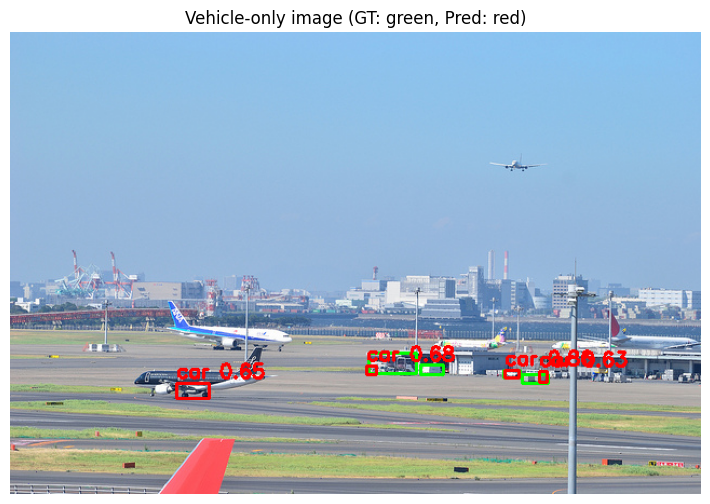

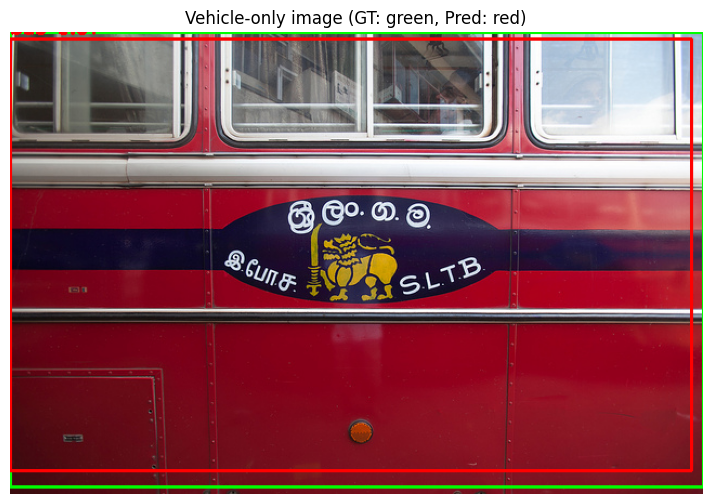

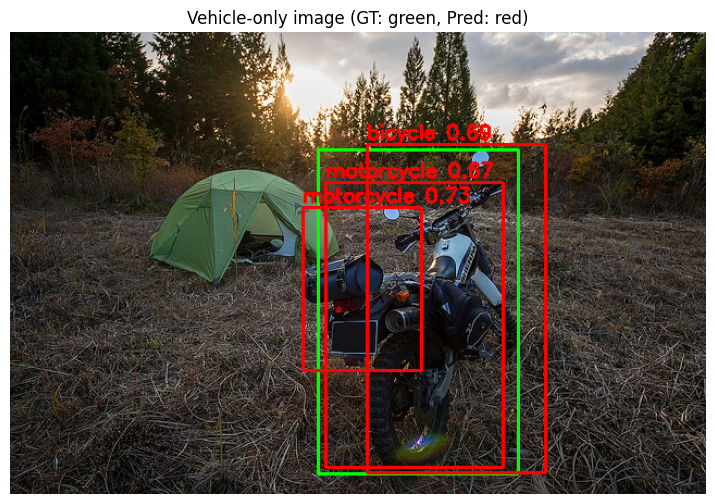

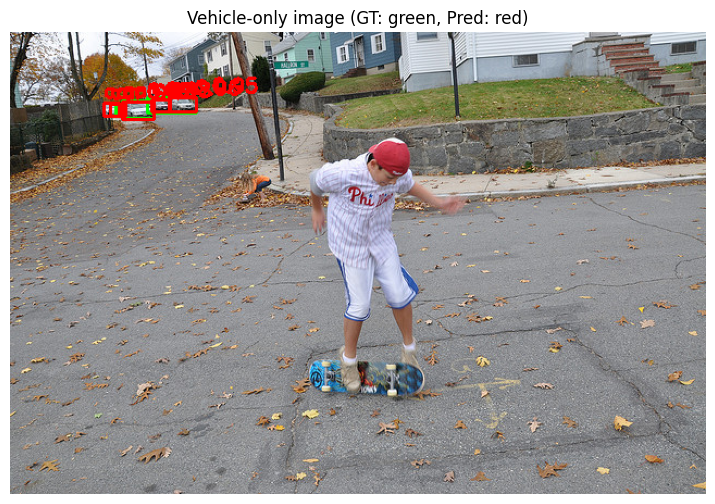

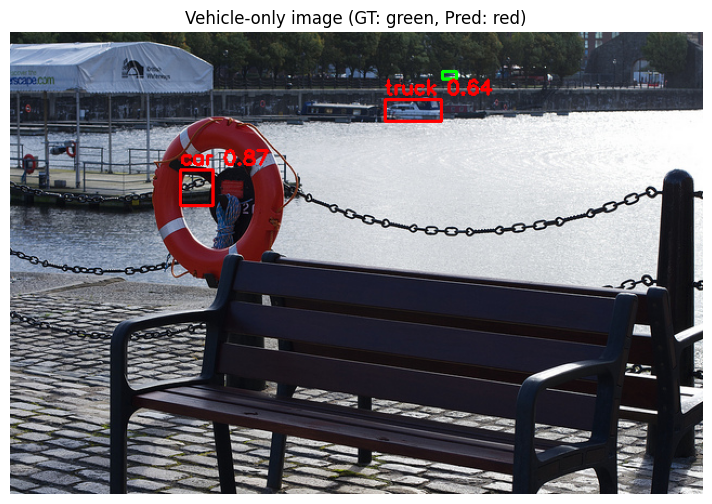

Displayed 5 images with vehicles.


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def visualize_detection_results_vehicle_only(
    model,
    dataset,
    n=5,
    score_thresh=0.5,
    seed=0,
):
    """
    Visualize ONLY images that contain at least one vehicle GT box.
    GT boxes: green
    Pred boxes: red
    """
    model.eval()
    rng = np.random.default_rng(seed)

    shown = 0
    attempts = 0
    max_attempts = 10_000  # safety

    while shown < n and attempts < max_attempts:
        attempts += 1
        idx = int(rng.integers(0, len(dataset)))

        img_t, target = dataset[idx]

        # --- KEY FILTER: skip images with no vehicle GT ---
        if target["boxes"].numel() == 0:
            continue

        img_in = img_t.to(device)
        out = model([img_in])[0]

        boxes_p = out["boxes"].cpu().numpy()
        scores_p = out["scores"].cpu().numpy()
        labels_p = out["labels"].cpu().numpy()

        keep = scores_p >= score_thresh
        boxes_p, scores_p, labels_p = boxes_p[keep], scores_p[keep], labels_p[keep]

        # Convert image
        vis = (img_t.permute(1,2,0).numpy() * 255).astype(np.uint8).copy()

        # Draw GT boxes (green)
        for (x1, y1, x2, y2) in target["boxes"].cpu().numpy().astype(int):
            cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)

        # Draw predictions (red)
        for (x1,y1,x2,y2), s, lab in zip(boxes_p.astype(int), scores_p, labels_p):
            coco_id = CONTIG_TO_COCO.get(int(lab))
            name = VEHICLE_COCO_CATS.get(coco_id, "veh")
            cv2.rectangle(vis, (x1,y1), (x2,y2), (255,0,0), 2)
            cv2.putText(
                vis, f"{name} {s:.2f}",
                (x1, max(0,y1-5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255,0,0),
                2,
            )

        plt.figure(figsize=(12,6))
        plt.imshow(vis)
        plt.title("Vehicle-only image (GT: green, Pred: red)")
        plt.axis("off")
        plt.show()

        shown += 1

    print(f"Displayed {shown} images with vehicles.")
    
visualize_detection_results_vehicle_only(
    model,
    val_ds,
    n=5,
    score_thresh=0.6,
    seed=42,
)

## Part B.1 — KITTI Flow 2015 Dataset

KITTI Flow 2015 provides:
- consecutive image pairs (t, t+1) from a driving camera
- ground-truth optical flow (sparse/occlusion-aware)

Your directory layout:
kitti2015/
  training/
    image_2/
    flow_occ/
    flow_noc/ (optional)

We will use:
- `training/image_2/*_10.png` as Frame t
- `training/image_2/*_11.png` as Frame t+1
- `training/flow_occ/*_10.png` as ground-truth flow

Note:
- Ground truth flow is stored in a special 16-bit PNG encoding.
- We must decode it into float flow vectors in pixels.


In [9]:
import torch
import torchvision
from torchvision.datasets import KittiFlow
from torchvision.models.optical_flow import raft_small

device = "cuda" if torch.cuda.is_available() else "cpu"

# Path should contain KITTI flow training data in the structure expected by torchvision  :contentReference[oaicite:8]{index=8}
KITTI_ROOT = "/home/frank/Desktop/data_scene_flow"  # change to your path

# split="train" uses the training set
kitti = KittiFlow(root=KITTI_ROOT, split="train", transforms=None)

print("KITTI train samples:", len(kitti))

KITTI train samples: 200


## Part B.2 — RAFT Model and Input Padding

We use a pretrained RAFT model from Torchvision.

Important constraint:
RAFT’s feature encoder downsamples spatial resolution by 8.
Therefore, the input image height and width must be divisible by 8.

If H or W is not divisible by 8, you may see:
`ValueError: The feature encoder should downsample H and W by 8`

Fix:
- **pad** the images to the next multiple of 8 (using replicate padding)
- run RAFT on padded images
- **unpad** the predicted flow back to the original image size

Padding (not resizing) preserves pixel geometry, so flow metrics remain meaningful.


In [10]:
from torchvision.models.optical_flow import Raft_Small_Weights

weights = Raft_Small_Weights.DEFAULT
flow_model = raft_small(weights=weights).to(device).eval()


## Part B.3 — Flow Metrics: EPE and Bad-pixel Rate

We compute two standard optical flow metrics:

### 1) EPE (Endpoint Error)
For each pixel:
EPE = sqrt( (u_pred - u_gt)^2 + (v_pred - v_gt)^2 )

We report the mean EPE over valid pixels.

### 2) Bad-pixel rate
A pixel is "bad" if its EPE exceeds a threshold (e.g., 3 pixels).
Bad-pixel rate = fraction of pixels with EPE > 3.

We optionally use a validity mask from the dataset to exclude invalid/occluded pixels.


In [11]:
import math
import numpy as np

def endpoint_error(flow_pred, flow_gt, valid_mask=None):
    """
    flow_pred, flow_gt: [B,2,H,W]
    valid_mask: [B,1,H,W] or [B,H,W] (True=valid)
    """
    diff = flow_pred - flow_gt
    epe = torch.sqrt(diff[:,0]**2 + diff[:,1]**2)  # [B,H,W]

    if valid_mask is not None:
        if valid_mask.ndim == 4:
            valid_mask = valid_mask[:,0]
        epe = epe[valid_mask]
    return epe.mean()

def bad_pixel_rate(flow_pred, flow_gt, thr=3.0, valid_mask=None):
    diff = flow_pred - flow_gt
    epe = torch.sqrt(diff[:,0]**2 + diff[:,1]**2)  # [B,H,W]

    if valid_mask is not None:
        if valid_mask.ndim == 4:
            valid_mask = valid_mask[:,0]
        epe = epe[valid_mask]

    return (epe > thr).float().mean()


## Part B.4 — Flow Visualization (GT vs RAFT Pred)

Optical flow is a 2D vector field per pixel.
We visualize flow using a standard HSV encoding:
- Hue represents **direction**
- Brightness/saturation represent **magnitude**

In the visualization:
- GT Flow shows the true motion field
- RAFT Pred shows the estimated motion field

How to interpret driving scenes:
- Large motion on the road is often due to **ego-motion** (the camera moving forward)
- Nearby objects typically show stronger flow than distant background
- Sharp boundaries indicate depth discontinuities or moving objects


In [12]:
import torch
import torch.nn.functional as F

def pad_to_multiple_of_8(img):
    """
    img: [B,3,H,W] float tensor
    Returns: padded_img, (pad_left, pad_right, pad_top, pad_bottom)
    """
    B, C, H, W = img.shape
    pad_h = (8 - (H % 8)) % 8
    pad_w = (8 - (W % 8)) % 8

    # pad format for F.pad is (left, right, top, bottom)
    pad = (0, pad_w, 0, pad_h)
    img_padded = F.pad(img, pad, mode="replicate")
    return img_padded, pad

def unpad_flow(flow, pad):
    """
    flow: [B,2,H_pad,W_pad]
    pad: (left, right, top, bottom)
    Returns: [B,2,H,W] cropped back to original size
    """
    left, right, top, bottom = pad
    H_pad = flow.shape[-2]
    W_pad = flow.shape[-1]
    return flow[:, :, top:H_pad-bottom, left:W_pad-right]

In [13]:
from torch.utils.data import DataLoader
def kitti_collate_fn(batch):
    """
    batch is a list of samples.
    We keep it as-is because KITTI images have variable resolution.
    """
    return batch

loader = DataLoader(
    kitti,
    batch_size=1,        # IMPORTANT: one sample at a time
    shuffle=False,
    num_workers=2,
    collate_fn=kitti_collate_fn
)


In [14]:
import numpy as np
import torch
from torchvision.transforms import functional as TF

@torch.no_grad()
def run_kitti_eval(model, loader, max_samples=50, thr=3.0):
    model.eval()
    epe_vals, bad_vals = [], []

    for i, batch in enumerate(loader):
        if i >= max_samples:
            break

        # If collate_fn returns list-of-samples for batch_size=1:
        sample = batch[0] if isinstance(batch, list) else batch

        if len(sample) == 4:
            img1, img2, flow_gt, valid = sample
        else:
            img1, img2, flow_gt = sample
            valid = None

        # --- images: PIL -> tensor ---
        if not torch.is_tensor(img1):
            img1 = TF.to_tensor(img1)
        if not torch.is_tensor(img2):
            img2 = TF.to_tensor(img2)

        img1 = img1.unsqueeze(0).to(device)  # [1,3,H,W]
        img2 = img2.unsqueeze(0).to(device)  # [1,3,H,W]

        # --- flow_gt: numpy -> torch ---
        if isinstance(flow_gt, np.ndarray):
            flow_gt = torch.from_numpy(flow_gt)

        # flow_gt could be [H,W,2] or [2,H,W]
        if flow_gt.ndim == 3 and flow_gt.shape[-1] == 2:
            flow_gt = flow_gt.permute(2, 0, 1)  # -> [2,H,W]

        if flow_gt.ndim == 3:
            flow_gt = flow_gt.unsqueeze(0)      # -> [1,2,H,W]
        flow_gt = flow_gt.float().cpu()

        # --- valid: numpy -> torch (optional) ---
        if valid is not None:
            if isinstance(valid, np.ndarray):
                valid = torch.from_numpy(valid)
            if torch.is_tensor(valid):
                # valid could be [H,W] or [1,H,W] or [H,W,1]
                if valid.ndim == 3 and valid.shape[-1] == 1:
                    valid = valid[..., 0]
                if valid.ndim == 2:
                    valid = valid.unsqueeze(0)  # [1,H,W]
                valid = valid.bool().cpu()

        # --- RAFT requires H,W divisible by 8: pad ---
        img1_pad, pad = pad_to_multiple_of_8(img1)
        img2_pad, _   = pad_to_multiple_of_8(img2)

        pred_list = model(img1_pad, img2_pad)
        flow_pred = unpad_flow(pred_list[-1], pad).cpu()  # [1,2,H,W]

        # --- metrics ---
        epe = endpoint_error(flow_pred, flow_gt, valid_mask=valid).item()
        bad = bad_pixel_rate(flow_pred, flow_gt, thr=thr, valid_mask=valid).item()

        epe_vals.append(epe)
        bad_vals.append(bad)

    return float(np.mean(epe_vals)), float(np.mean(bad_vals))


epe_mean, bad_mean = run_kitti_eval(flow_model, loader, max_samples=50)
print("KITTI subset EPE:", epe_mean, "Bad-px@3:", bad_mean)


KITTI subset EPE: 4.957618675231934 Bad-px@3: 0.21661574866622688


## Part B.5 — Visualize Multiple Scenes

Single examples can be misleading. We visualize multiple (e.g., 5) random KITTI scenes to see:
- typical behavior
- consistent patterns
- failure cases (thin structures, occlusions, boundaries)

**Exercise suggestion:**
- change the random seed to sample different scenes
- identify at least 2 failure modes and propose a fix
  (e.g., multi-scale refinement, occlusion reasoning, higher-res inference)


In [15]:
import numpy as np
import cv2
import torch

def flow_to_rgb(flow):
    """
    Convert optical flow to RGB visualization using HSV color wheel.

    Args:
        flow: torch.Tensor or np.ndarray of shape [2, H, W]
              flow[0] = horizontal (u), flow[1] = vertical (v)

    Returns:
        rgb image of shape [H, W, 3] (uint8)
    """
    if torch.is_tensor(flow):
        flow = flow.detach().cpu().numpy()

    assert flow.ndim == 3 and flow.shape[0] == 2, \
        f"Expected flow shape [2,H,W], got {flow.shape}"

    u = flow[0]
    v = flow[1]

    # Magnitude and angle
    mag, ang = cv2.cartToPolar(u, v, angleInDegrees=True)

    # HSV image
    hsv = np.zeros((u.shape[0], u.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = (ang / 2).astype(np.uint8)   # Hue: direction
    hsv[..., 1] = 255                          # Saturation
    hsv[..., 2] = np.clip(mag * 10, 0, 255)    # Value: magnitude

    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

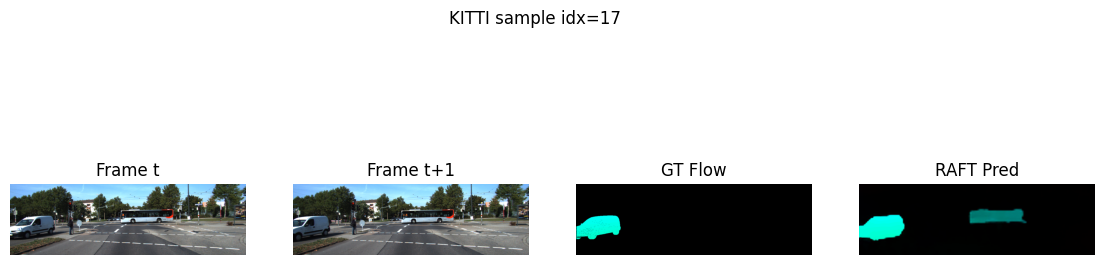

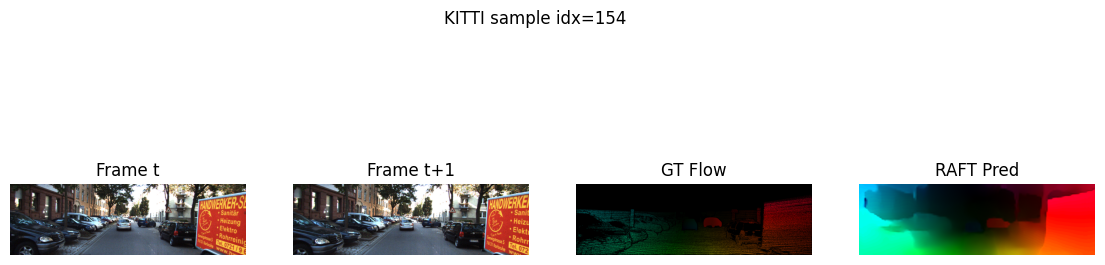

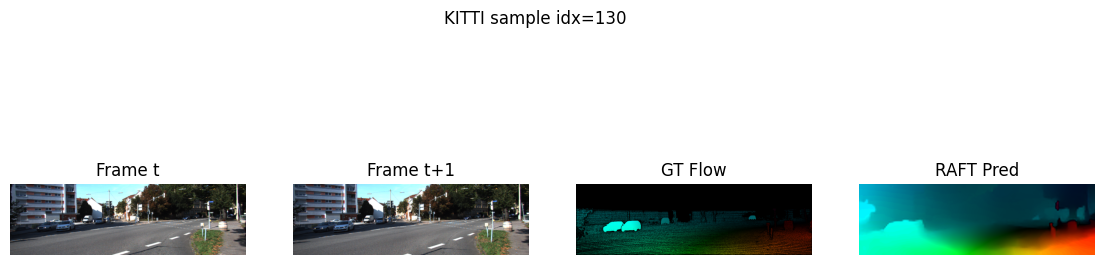

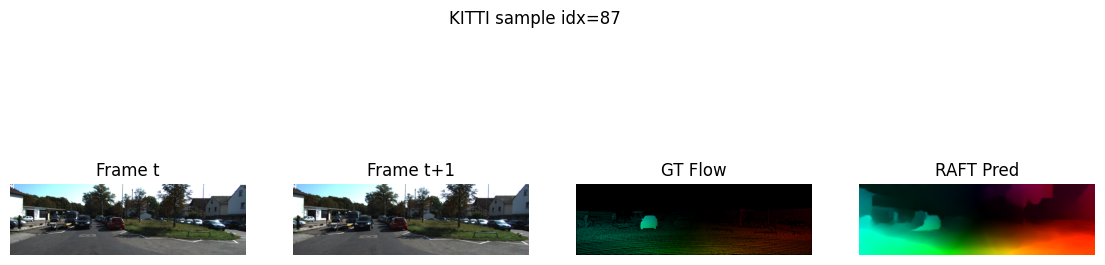

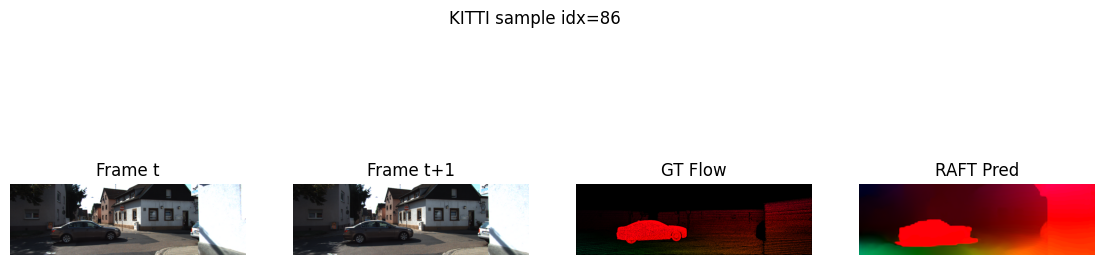

In [16]:
import numpy as np
import torch
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_kitti_samples(model, dataset, n=5, seed=0, indices=None):
    """
    Visualize n KITTI scenes: (frame t, frame t+1, GT flow, RAFT pred).
    Uses pad_to_multiple_of_8 + unpad_flow to satisfy RAFT constraints.
    
    If indices is provided, it must be a list of dataset indices to visualize.
    """
    model.eval()
    rng = np.random.default_rng(seed)

    if indices is None:
        indices = [int(rng.integers(0, len(dataset))) for _ in range(n)]
    else:
        n = len(indices)

    for idx in indices:
        sample = dataset[idx]
        if len(sample) == 4:
            img1, img2, flow_gt, valid = sample
        else:
            img1, img2, flow_gt = sample
            valid = None

        # Images -> tensor + numpy for display
        if not torch.is_tensor(img1):
            img1_np = np.array(img1)
            t1 = TF.to_tensor(img1)
        else:
            t1 = img1
            img1_np = (t1.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

        if not torch.is_tensor(img2):
            img2_np = np.array(img2)
            t2 = TF.to_tensor(img2)
        else:
            t2 = img2
            img2_np = (t2.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

        # Flow GT -> tensor [2,H,W]
        if isinstance(flow_gt, np.ndarray):
            flow_gt_t = torch.from_numpy(flow_gt)
        else:
            flow_gt_t = flow_gt

        if flow_gt_t.ndim == 3 and flow_gt_t.shape[-1] == 2:
            flow_gt_t = flow_gt_t.permute(2,0,1)
        flow_gt_t = flow_gt_t.float()

        # RAFT inference with padding
        t1b = t1.unsqueeze(0).to(device)
        t2b = t2.unsqueeze(0).to(device)

        t1_pad, pad = pad_to_multiple_of_8(t1b)
        t2_pad, _   = pad_to_multiple_of_8(t2b)

        pred_list = model(t1_pad, t2_pad)
        pred_flow = unpad_flow(pred_list[-1], pad)[0].cpu()  # [2,H,W]

        # Plot
        plt.figure(figsize=(14,4))
        plt.suptitle(f"KITTI sample idx={idx}", y=1.02)

        plt.subplot(1,4,1); plt.imshow(img1_np); plt.title("Frame t"); plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(img2_np); plt.title("Frame t+1"); plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(flow_to_rgb(flow_gt_t)); plt.title("GT Flow"); plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(flow_to_rgb(pred_flow)); plt.title("RAFT Pred"); plt.axis("off")

        plt.show()

visualize_kitti_samples(flow_model, kitti, n=5, seed=42)
